In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [221]:
def habitable_zone(luminosity):
    '''
    Luminosity is in units of solar luminosity. Outputs in AU.
    '''
    r_inner = np.sqrt(luminosity/1.1) # https://www.planetarybiology.com/downloads/Estimating%20the%20habitable%20zone%2010_17_10_revised_8_19.pdf
    r_outer = np.sqrt(luminosity/0.53)
    r_mean = 0.5*(r_inner + r_outer)
    
#     print('Inner Radius: ' + str(r_inner))
#     print('Outer Radius: ' + str(r_outer))
#     print('Mean Radius: ' + str(r_mean))
    return r_inner

def habitable_zone2(luminosity, temperature):
    '''
    recent venus model from https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/pdf
    Temp is in kelvin
    '''
    T_star = temperature - 5780
    S_star = 1.7753#1.0140
    a = 1.4316e-4#8.1774e-5
    b = 2.9875e-9#1.7063e-9
    c = -7.5702e-12#-4.3241e-12
    d = -1.1635e-15#-6.6462e-16
    Seff = S_star + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    
    hz = np.sqrt(luminosity/Seff)
    return hz

def astrometric_signal(luminosity, temperature, distance, stellar_mass):
    '''
    Luminosity is in units of solar luminosity. Distance in Parsecs. Stellar_mass in solar
    masses. Returns micro arc seconds.
    '''
    solar_mass = 2 * 1e30
    Earth_mass = 6 * 1e24
    star_mass = stellar_mass * solar_mass
    a = habitable_zone(luminosity)
    signal = ((Earth_mass)/(star_mass)) * a * (1/distance)
    return signal*1e6

In [222]:
#print(habitable_zone(1))
print(astrometric_signal(1.5,5790,1.34,1.07))
print(astrometric_signal(0.5,5260, 1.34, 0.9))
print(astrometric_signal(0.153,4526, 3.49,0.7))

2.4433290896407116
1.6771140857294575
0.45798068314142854


In [131]:
# open data and turn it into a pandas dataframe

input_file = open('near10pc_TOLIMAN.txt')
lines = []
for line in input_file:
    lines.append(line)

split = []
for i in range(len(lines)):
    split.append(lines[i].split())


header = split[0][:5]
data = split[2:]


a = []
for i in range(len(data)):
    a.append(data[i])
    
# add additional columns
near10pc = pd.DataFrame(a)
near10pc.columns = ['Name', 'Spectrum', 'Vmag', 'Abs_Mag', 'Dist_Ly']
near10pc[['Vmag', 'Abs_Mag', 'Dist_Ly']] = near10pc[['Vmag', 'Abs_Mag', 'Dist_Ly']].astype(float)
near10pc['Dist_pc'] = near10pc['Dist_Ly']*0.3066 # convert Ly to Pc
near10pc['Simple_Spectrum'] = near10pc['Spectrum'].str.slice(0,2)# 2 letter spectral type
near10pc.head()

,Name,Spectrum,Vmag,Abs_Mag,Dist_Ly,Dist_pc,Simple_Spectrum
0,Alp_Cen_A,G2V,-0.01,4.340,4.36,1.336776,G2
1,Alp_Cen_B,K1V,1.35,5.700,4.36,1.336776,K1
2,Sirius_A,A1V,-1.46,1.420,8.60,2.636760,A1
3,61_Cyg_A,K5V,5.20,7.490,11.40,3.495240,K5
4,61_Cyg_B,K7V,6.05,8.319,11.40,3.495240,K7


In [167]:
# open sdata and turn it into a dataframe
input_file = open('mamajek_star_data.txt')
lines = []
for line in input_file:
    lines.append(line)

split = []
for i in range(len(lines)):
    split.append(lines[i].split())

header = split[13]
data = split[14:]

a = []
for i in range(len(data)):
    a.append(data[i])
    
sdata = pd.DataFrame(a)
sdata.columns = header
sdata = sdata.loc[:,~sdata.columns.duplicated()] # removes repeated columns
sdata[['Teff','logL','Msun']] = sdata[['Teff','logL','Msun']].astype(float)
sdata.head()

,#SpT,Teff,logT,BCv,Mv,logL,U-B,B-V,V-Ic,V-Ks,J-H,H-K,Ks-W1,Msun,lgAge,b-y,M_J,M_K,Mbol
0,O9V,33000.0,4.519,-3.09,-4.20,4.81,-1.114,-0.311,-0.369,-1.000,-0.164,-0.071,...,21.0,6.6,-0.128,-3.44,-3.20,-7.29
1,O9.5V,31900.0,4.504,-3.02,-4.00,4.70,-1.087,-0.305,-0.361,-0.977,-0.161,-0.069,...,20.0,6.7,-0.125,-3.25,-3.02,-7.02
2,B0V,31500.0,4.498,-2.99,-3.90,4.65,-1.070,-0.300,-0.355,-0.961,-0.159,-0.068,...,18.0,6.8,-0.121,-3.17,-2.94,-6.89
3,B0.5V,28500.0,4.455,-2.79,-3.70,4.49,-1.026,-0.295,-0.338,-0.913,-0.153,-0.063,...,15.0,6.9,-0.120,-3.00,-2.79,-6.49
4,B1V,26000.0,4.415,-2.57,-2.80,4.05,-0.995,-0.278,-0.325,-0.874,-0.147,-0.058,...,12.0,7.0,-0.114,-2.13,-1.93,-5.37


In [189]:
Lbol = 10**sdata['logL']
Hz_Orbit = np.sqrt(Lbol)
Stellar_Mass = sdata['Msun']
Stellar_Type = sdata['#SpT'].str.slice(0,2)
Stellar_Temp = sdata['Teff']

Planet_Period = np.sqrt(Hz_Orbit**3 / Stellar_Mass)

Mplanet = 1  #in M_Earths

1.0427973386391731


Alp_Cen_A: 2.278
Alp_Cen_B: 1.685
Sirius_A: 2.622
61_Cyg_A: 0.472
61_Cyg_B: 0.405
Procyon_A: 1.200
Struve2398_A: 0.308
Struve2398_B: 0.278
Goombridge34_A: 0.292
Goombridge34_B: 0.276
Groombridge1618: 0.290
Omi2_Eri_A: 0.445
Omi2_Eri_C: 0.194
70_Oph_A: 0.453
70_Oph_B: 0.334
Gl_570_A: 0.283
Gl_570_B: 0.178
Eta_Cass_A: 0.499
Eta_Cass_B: 0.238
36_Oph_A: 0.344
36_Oph_B: 0.377
36_Oph_C: 0.276
HR_7703_A: 0.316
HR_7703_B: 0.163
HR_8832: 0.290
Xi_Boo_A: 0.386
Xi_Boo_B: 0.253
Gl_667_A: 0.280
Gl_667_B: 0.243
Gl_667_C: 0.153
P_Eri_A: 0.263
P_Eri_B: 0.263
HD_50281_A: 0.218
HD_50281_B: 0.118
41_Ara_A: 0.295
41_Ara_B: 0.262
Xi_UMa_A: 0.411
Xi_UMa_B: 0.375
Gam_Lep_A: 0.433
Gam_Lep_B: 0.229


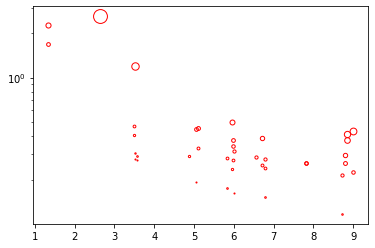

In [228]:
n_stars = len(near10pc['Dist_pc'])
near10pc_alpha = np.zeros(n_stars) # astrometric signal
near10pc_teff = np.zeros(n_stars)
near10pc_orbitperiod = np.zeros(n_stars)

for i in range(n_stars):
    star_type = near10pc['Simple_Spectrum'][i]
    idx = sdata[sdata['#SpT'].str.match(star_type)].index[0]
    
    near10pc_alpha[i] = 3 * Mplanet / Stellar_Mass[idx] * Hz_Orbit[idx] / near10pc['Dist_pc'][i]
    near10pc_teff[i] = Stellar_Temp[idx]
    near10pc_orbitperiod[i] = Planet_Period[idx]
    
    plt.plot(near10pc['Dist_pc'][i], near10pc_alpha[i], 'o', mfc = 'none' , 
             markersize = np.sqrt(near10pc_orbitperiod[i])*5, color = 'red')
    plt.yscale('log')
    
    print(near10pc['Name'][i] + ': {:.3f}'.format(near10pc_alpha[i]))

In [241]:
near10pc['Signal'] = near10pc_alpha
near10pc['Period'] = near10pc_orbitperiod
sorted_near10pc = near10pc.sort_values(by = ['Signal'], ascending = False)


In [242]:
print(sorted_near10pc[['Name','Signal', 'Period']])

               Name    Signal    Period
2          Sirius_A  2.621972  7.696418
0         Alp_Cen_A  2.277521  1.042797
1         Alp_Cen_B  1.684861  0.559436
5         Procyon_A  1.200266  2.211633
17       Eta_Cass_A  0.498594  0.982879
3          61_Cyg_A  0.471610  0.305471
13         70_Oph_A  0.452951  0.599522
11       Omi2_Eri_A  0.445212  0.559436
38        Gam_Lep_A  0.433283  1.847332
36         Xi_UMa_A  0.411410  1.572385
4          61_Cyg_B  0.405009  0.207448
25         Xi_Boo_A  0.386347  0.755851
20         36_Oph_B  0.376718  0.559436
37         Xi_UMa_B  0.374740  1.262661
19         36_Oph_A  0.343634  0.481715
14         70_Oph_B  0.333692  0.332241
22        HR_7703_A  0.316088  0.408091
6      Struve2398_A  0.307999  0.078406
34         41_Ara_A  0.294808  0.755851
8    Goombridge34_A  0.291802  0.105803
10  Groombridge1618  0.290384  0.207448
24          HR_8832  0.289501  0.408091
15         Gl_570_A  0.282966  0.305471
27         Gl_667_A  0.280331  0.408091
